<a href="https://colab.research.google.com/github/AarshiMukherjee/Market-Interaction-Based-Company-Performance-Predictor/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Load the dataset in colab environment
import pandas as pd
import numpy as np
df=pd.read_csv("/content/National_Stock_Exchange_of_India_Ltd.csv")

In [18]:
#Convert to numerical
numeric_cols = [
    'Open','High','Low','LTP','Chng','% Chng',
    'Volume (lacs)','Turnover (crs.)',
    '52w H','52w L','365 d % chng','30 d % chng'
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')


In [19]:
#Mean Imputation to fill NaN values
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
df.isnull().sum()

,0
Symbol,0
Open,0
High,0
Low,0
LTP,0
Chng,0
% Chng,0
Volume (lacs),0
Turnover (crs.),0
52w H,0


After performing EDA, we found out that the %chng, Volume, Turnover, 365 d % chng and 30 d % chng are the most important features to understand relationship between stocks. we further use these features to train a K-Means clustering model to understand related sectors.

In [20]:
features = [
    '% Chng',
    'Volume (lacs)',
    'Turnover (crs.)',
    '365 d % chng',
    '30 d % chng'
]

X = df[features]


In [21]:
#K-Means is distance-based, so scaling is required.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


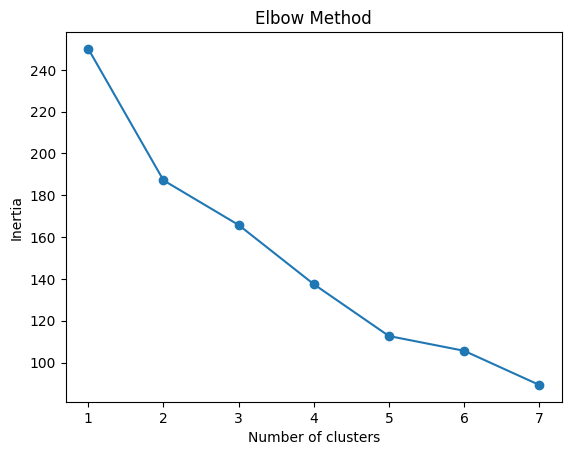

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
inertia = []

for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1,8), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


K=3 Chosen even though no clear elbow is chosen as K=3 is commonly chosen

In [24]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


In [26]:
#Display which company falls into which cluster
df[['Symbol', 'Cluster']].sort_values('Cluster')


,Symbol,Cluster
1,ASIANPAINT,0
3,BAJAJ-AUTO,0
13,EICHERMOT,0
14,GRASIM,0
12,DRREDDY,0
11,DIVISLAB,0
9,CIPLA,0
8,BRITANNIA,0
15,HCLTECH,0
21,HINDUNILVR,0


Now we have grouped comapnies into clusters (**0= ** and we further group them by considering the mean of features taken into account earlier
This tells us:

1. Which cluster has high growth (high volume, turnover)

2. Which cluster is volatile (high %chng)

3. Which cluster is stable / low return (low volume, turnover)

In [27]:
df.groupby('Cluster')[features].mean()


,% Chng,Volume (lacs),Turnover (crs.),365 d % chng,30 d % chng
Cluster,,,,,
0,-1.577778,27.365556,285.133774,33.564815,-2.770370
1,-4.903333,149.760000,618.377817,69.996667,-6.072500
2,-4.097273,93.394545,412.540866,28.540000,-13.833636


Meaning of each cluster
1. Cluster 0 (Stable group)

-> Small daily change (% Chng ~ -1.6)

-> Lowest volume & turnover

-> Moderate 1-year growth (~33%)

-> Slight short-term decline

These are stable, less volatile companies. They don’t change much daily and are often large, defensive brands/PSUs/mainly domestic needs comapnies.
Examples: HUL, ITC, TCS, Nestle, Asian Paints.

2. Cluster 1 (High-growth, high-activity group)

-> Bigger daily drops (% Chng ~ -4.9)

-> Highest volume & turnover

-> Best 1-year performance (~70%)

-> Short-term weakness

These are popular, actively traded companies that have done very well long-term but are currently correcting. They contribute to country's economic development and GDP.

Examples: Adani Ports, Maruti, Tata Motors, JSW Steel.

3. Cluster 2 (Volatile group)

-> Daily change (% Chng ~ +4.1)

-> Medium trading activity

-> Lower long-term growth (~28%)

-> Strong short-term drop

These stocks are more volatile and news-driven, often from banking, energy, or commodities.

Examples: Banks, Reliance, Tata Steel, NTPC.

**OBSERVATIONS**

1. Banks mostly fall in Cluster 2

2. FMCG / IT companies dominate Cluster 0

3. Capital-intensive or growth stocks appear in Cluster 1